# NPZD slab model

For the first model example I will need:
- Forcing input
- Forcing_fluxes:
    - mixing
    - sinking
- 4 components (single) N, P, Z, D
- Fluxes:
TODO: GO OVER THE equations! Base model structure in math!
    - Grazing - linked to all NPZD
    - PhytoplanktonGrowth
        - Light - Dependence
        - Nutrients - Dependence
        - Temp - Dependence
    - mortality
    - remineralisation
    - higher order pred, etc

In [1]:
import xsimlab as xs
import numpy as np

In [2]:
import os,sys,inspect
sys.path.insert(1, os.path.join(sys.path[0], '..'))

import phydra

In [3]:
from phydra.utility.xsimlabwrappers import phydra_setup

In [4]:
from phydra.processes.main import GekkoCore, GekkoContext, GekkoSequentialSolve, Time

from phydra.processes.statevars import StateVariable, FunctionalGroup

from phydra.processes.fluxes import (InFlux, LinearExchangeFlux,LinearLossFlux, MonodUptake, Growth_MultiLim, 
                                    GML_MonodUptake, GML_EppleyTempLim, GML_SteeleLightLim,
                                    GrazingFlux, GrazingFlux_MultiRessource,
                                    QuadraticLossFlux, QuadraticExchangeFlux, Sinking, Mixing, Upwelling)

from phydra.processes.forcings import ConstantForcing, SinusoidalForcing, GlobalSlabClimatologyForcing

from phydra.processes.paramsetup import GrowthParameterSetup

In [5]:
from phydra.processes.forcings import Forcing

In [6]:
print('xarray-simlab version: ', xs.__version__)
print('phydra version: ', phydra.__version__)

xarray-simlab version:  0.4.1
phydra version:  0+untagged.93.g5bac7e0.dirty


In [7]:
MODEL = xs.Model({
                # CORE
                'core':GekkoCore, 
                'solver':GekkoSequentialSolve, 

                'time':Time, 
                
                # STATE VARIABLES
                'N':StateVariable, 
                'P':StateVariable,
                'Z':StateVariable, 
                'D':StateVariable,
                
                # FLUXES
                # setup classmethod allows multiple instances of Growth_MultiLim process
                # and GML_... processes in same model
                  # Pro: flexible, Con: less understandable code
                
                #'monod':MonodUptake,
                'growth':Growth_MultiLim.setup('_P'),
                'monod':GML_MonodUptake.setup('_P'),
                
                'eppley':GML_EppleyTempLim.setup('_P'),
                'steele':GML_SteeleLightLim.setup('_P'),

                # note, grazing does not include setup class method (only 1 instance possible)
                  # (design choice not yet settled)
                'grazing':GrazingFlux_MultiRessource,
                
                'P_mortality':LinearExchangeFlux,
                'P_quadmortality':QuadraticExchangeFlux,
                'Z_mortality':LinearExchangeFlux,
                'Z_quadmortality':QuadraticLossFlux,
    
                'D_remin':LinearExchangeFlux,
    
                'Sinking':Sinking,
    
                'Mixing':Mixing,
    
                'N_upwelling':Upwelling,
                
                # FORCING
                'N0':GlobalSlabClimatologyForcing,
                'Temp':GlobalSlabClimatologyForcing,
                'I0':GlobalSlabClimatologyForcing,
                'MLD':GlobalSlabClimatologyForcing,
                })

MODEL

<xsimlab.Model (24 processes, 77 inputs)>
core
solver
time
    days                [in] ('time',) time in days
N
    initVal             [in] initial value of component
P
    initVal             [in] initial value of component
Z
    initVal             [in] initial value of component
D
    initVal             [in] initial value of component
MLD
    lon                 [in]
    k                   [in] The degree of the spline fit
    dataset             [in] Options: 'n0x', 'mld', 'tmld', 'par'
    smooth              [in] smoothing conditions, larger values = ...
    rbb                 [in]
    lat                 [in]
    show_plot           [in] show plot of interpolated data and int...
Temp
    show_plot           [in] show plot of interpolated data and int...
    k                   [in] The degree of the spline fit
    dataset             [in] Options: 'n0x', 'mld', 'tmld', 'par'
    smooth              [in] smoothing conditions, larger values = ...
    rbb                 [in]


In [8]:
in_ds = phydra_setup(model=MODEL,
                        input_vars={
                            'time__days': ('time', np.arange(0, 365*5)),
                            
                            'N':{'initVal':0.1},
                            'P':{'initVal':.01},
                            'Z':{'initVal':.01},
                            'D':{'initVal':.01},
                            
                            'growth':{'source_label':'N',
                                    'sink_label':'P',
                                    'mumax':1.},
                            'monod':{'halfsat':0.85},
                            'eppley':{'FX_label':'Temp',
                                      'exponent':0.063},
                            'steele':{'FX_label_I0':'I0',
                                      'FX_label_MLD':'MLD',
                                      'IOpt':5.,
                                      'kw':0.04,
                                      'kc':0.03},
                            
                            'grazing':{'source_labels':['P','D'],
                                       'sink_label':'Z',
                                       'egested2_label':'D',
                                       'excreted2_label':'N',
                                       
                                       'Imax':1.,
                                       'kZ':0.6,
                                       'epsilon':0.75,
                                       'beta':0.69,
                                      
                                       'feed_prefs':[0.67, 0.33]},
                            
                            'P_mortality':{'source_label':'P',
                                           'sink_label':'D',
                                           'rate':0.015},
                            
                            'P_quadmortality':{'source_label':'P',
                                           'sink_label':'D',
                                           'rate':0.025},
                            
                            'Z_mortality':{'source_label':'Z',
                                           'sink_label':'D',
                                           'rate':0.02},
                            
                            'Z_quadmortality':{'SV_label':'Z',
                                           'rate':0.34},
                            
                            'D_remin':{'sink_label':'N',
                                       'source_label':'D',
                                       'rate':0.1
                                      },
                            
                            'Sinking':{'SV_labels':['D'],
                                      'FX_label_MLD':'MLD',
                                      'sinking_rate':6.34},
                            
                            'Mixing':{'SV_labels':['P', 'D', 'Z'], #,'Z','D'],
                                      'FX_label_MLD':'MLD',
                                      'kappa':0.13},
                            
                            'N_upwelling':{'SV_label':'N',
                                      'FX_label_MLD':'MLD',
                                      'FX_label_N0':'N0',
                                      'kappa':0.13},
                            
                            'N0':{'lat':47,'lon':-20,'rbb':2,'smooth':5, 'k':2,
                                   'dataset':'n0x', 'show_plot':True},
                            'Temp':{'lat':47,'lon':-20,'rbb':2,'smooth':5, 'k':2,
                                   'dataset':'tmld', 'show_plot':True},
                            'I0':{'lat':47,'lon':-20,'rbb':2,'smooth':10, 'k':2,
                                   'dataset':'par', 'show_plot':True},
                            'MLD':{'lat':47,'lon':-20,'rbb':2,'smooth':400, 'k':2,
                                   'dataset':'mld', 'show_plot':True}

                        },
                        output_vars={
                            # State Variables
                            'N__value':None,
                            'P__value':None,
                            'Z__value':None,
                            'D__value':None,
                            
                            # Fluxes
                            'growth__value':None,
                            'P_mortality__value':None,
                            'P_quadmortality__value':None,
                            'Z_mortality__value':None,
                            'Z_quadmortality__value':None,
                            'grazing__values':None,
                            
                            # Forcing
                            'N0__value':None,
                            'MLD__value':None,
                            'MLD__deriv':None,
                            'Temp__value':None,
                            'I0__value':None,
                            
                            # Forcing Fluxes
                            'N_upwelling__value':None,
                            'Mixing__values':None
                        })

initializing model core
Initializing Model Time
state variable N is initialized
state variable P is initialized
state variable Z is initialized
state variable D is initialized
forcing MLD is initialized
[161.35449219 185.17585754 201.55308533 180.43736267  82.22182465
  35.41545486  23.00223732  19.88839531  21.0316143   34.70539093
  49.20352173  78.45903778 137.53314209 161.35449219] [  0.   15.5  45.   74.5 105.  135.5 166.  196.5 227.5 258.  288.5 319.
 349.5 365. ]


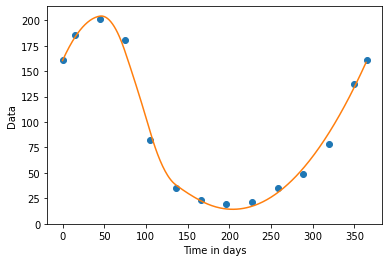

[161.35449219 185.17585754 201.55308533 180.43736267  82.22182465
  35.41545486  23.00223732  19.88839531  21.0316143   34.70539093
  49.20352173  78.45903778 137.53314209 161.35449219] [  0.   15.5  45.   74.5 105.  135.5 166.  196.5 227.5 258.  288.5 319.
 349.5 365. ]


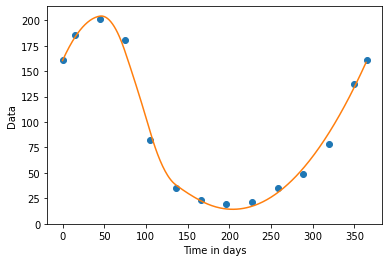

forcing Temp is initialized
[12.79647964 12.4523378  12.10065532 12.0675441  12.3068648  13.07369763
 14.73500854 16.77011669 17.74150705 17.53237057 16.06950957 14.2295441
 13.14062148 12.79647964] [  0.   15.5  45.   74.5 105.  135.5 166.  196.5 227.5 258.  288.5 319.
 349.5 365. ]


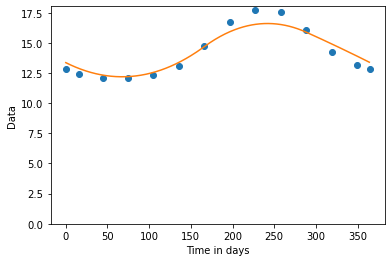

[12.79647964 12.4523378  12.10065532 12.0675441  12.3068648  13.07369763
 14.73500854 16.77011669 17.74150705 17.53237057 16.06950957 14.2295441
 13.14062148 12.79647964] [  0.   15.5  45.   74.5 105.  135.5 166.  196.5 227.5 258.  288.5 319.
 349.5 365. ]


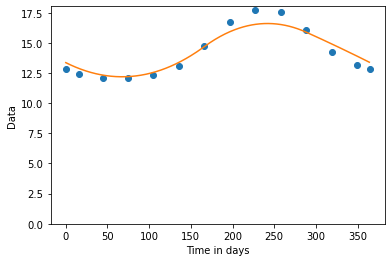

forcing N0 is initialized
[5.17510905 5.94718865 7.6670433  6.56061161 6.26570198 4.08289021
 1.15164541 0.35991846 0.10639992 0.22115108 1.14229975 3.32657784
 4.40302946 5.17510905] [  0.   15.5  45.   74.5 105.  135.5 166.  196.5 227.5 258.  288.5 319.
 349.5 365. ]


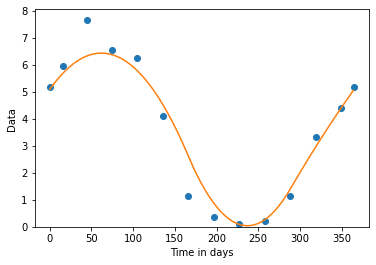

[5.17510905 5.94718865 7.6670433  6.56061161 6.26570198 4.08289021
 1.15164541 0.35991846 0.10639992 0.22115108 1.14229975 3.32657784
 4.40302946 5.17510905] [  0.   15.5  45.   74.5 105.  135.5 166.  196.5 227.5 258.  288.5 319.
 349.5 365. ]


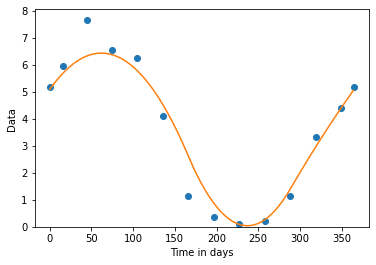

forcing I0 is initialized
[ 7.2505722   7.97908974 14.06657505 23.41232491 33.64842606 41.69817352
 45.07362747 42.20851517 38.27270889 27.82722664 17.30537415  9.68299961
  6.52205467  7.2505722 ] [  0.   15.5  45.   74.5 105.  135.5 166.  196.5 227.5 258.  288.5 319.
 349.5 365. ]


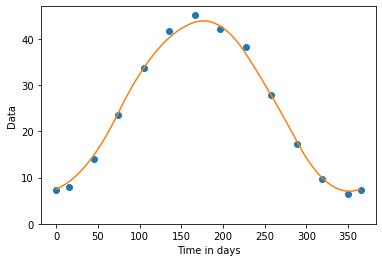

[ 7.2505722   7.97908974 14.06657505 23.41232491 33.64842606 41.69817352
 45.07362747 42.20851517 38.27270889 27.82722664 17.30537415  9.68299961
  6.52205467  7.2505722 ] [  0.   15.5  45.   74.5 105.  135.5 166.  196.5 227.5 258.  288.5 319.
 349.5 365. ]


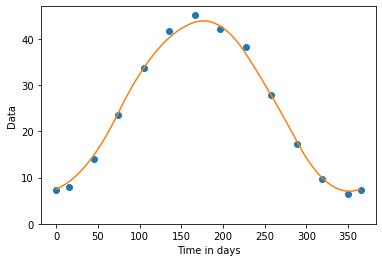

flux growth of P consuming N is initialized
flux grazing of Z consuming ['P' 'D'] is initialized 
 egesting to D and excreting to N
['P', 'D']
[((((((((1.0)*(((p)^(2)))))*(0.67)))/((0.36+(((((p)^(2)))*(0.67))+((((d)^(2)))*(0.33)))))))*(z)), ((((((((1.0)*(((d)^(2)))))*(0.33)))/((0.36+(((((p)^(2)))*(0.67))+((((d)^(2)))*(0.33)))))))*(z))]
flux P_mortality of D consuming P is initialized
flux P_quadmortality of D consuming P is initialized
flux Z_mortality of D consuming Z is initialized
flux Z_quadmortality acting on Z is initialized
flux D_remin of N consuming D is initialized
flux Sinking acting on ['D'] is initialized
['D']
[((((d)*(6.34)))/(mld))]
flux Mixing acting on ['P' 'D' 'Z'] is initialized
['P', 'D', 'Z']
[((p)*((((hpos+0.13))/(mld)))), ((d)*((((hpos+0.13))/(mld)))), ((z)*((((hpos+0.13))/(mld))))]
flux N_upwelling acting on N is initialized
assembling equations for state variable N
defaultdict(<class 'list'>, {'N': [(-((((1.0)*(((((exp(((0.063)*(temp))))*(steele)))*(((n)/((0.8

In [9]:
with MODEL:
    out_ds = in_ds.xsimlab.run()

In [10]:
print(out_ds)

<xarray.Dataset>
Dimensions:                        (clock: 2, loss_index: 3, loss_index2: 1, source_index: 2, time: 1825)
Coordinates:
  * clock                          (clock) int64 0 1
  * source_index                   (source_index) <U1 'P' 'D'
  * time                           (time) int64 0 1 2 3 ... 1821 1822 1823 1824
Dimensions without coordinates: loss_index, loss_index2
Data variables:
    D__initVal                     float64 0.01
    D__value                       (time) float64 0.01 0.008922 ... 0.4133
    D_remin__rate                  float64 0.1
    D_remin__sink_label            <U1 'N'
    D_remin__source_label          <U1 'D'
    I0__dataset                    <U3 'par'
    I0__k                          int64 2
    I0__lat                        int64 47
    I0__lon                        int64 -20
    I0__rbb                        int64 2
    I0__show_plot                  bool True
    I0__smooth                     int64 10
    I0__value                   

In [11]:
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [12, 5]

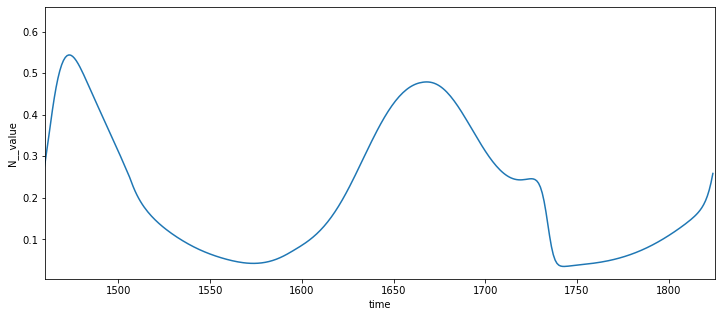

In [12]:
out_ds.N__value.plot.line(x='time', xlim=(365*4,365*5))

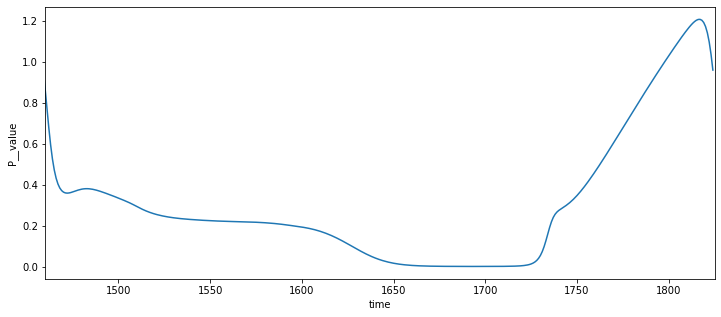

In [13]:
out_ds.P__value.plot.line(x='time', xlim=(365*4,365*5))

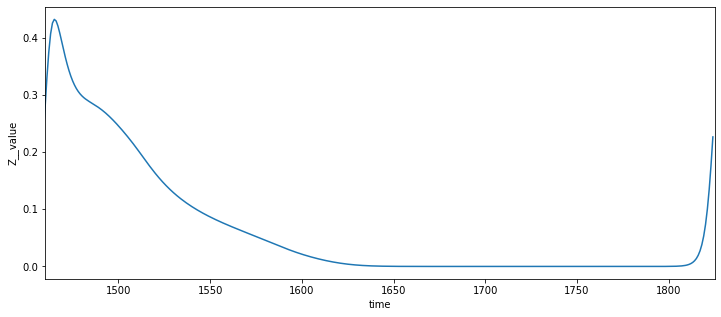

In [14]:
out_ds.Z__value.plot.line(x='time', xlim=(365*4,365*5))

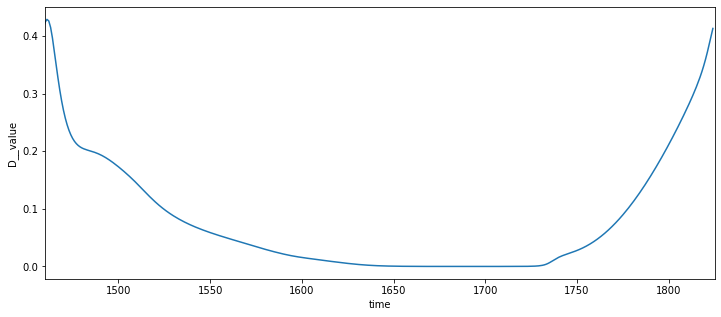

In [15]:
out_ds.D__value.plot.line(x='time', xlim=(365*4,365*5))

In [76]:
#out_ds.P__value.values[1460:1825]

In [4]:
from phydra.utility.forcingdata import VerifData

verifdat = VerifData(lat=47, lon=-20, rbb=2)

VerifData forcing created


In [5]:
Nut_Verif = verifdat.N

Chla_Verif = verifdat.chla

In [7]:
Nut_Verif
Chla_Verif

[0.21719593,
 0.22822902,
 0.32341284,
 0.517609,
 0.79371387,
 0.66048664,
 0.43114161,
 0.3648323,
 0.33067486,
 0.36059904,
 0.31265676,
 0.25592265]

In [79]:

loc_trop = [-20, 0]
loc_temp = [-20, 47]
rbb = 2.

trop_col = 'red'
temp_col = 'blue'


labels = {'model_pico':'darkgreen','model_nano':'green','model_micro':'lightgreen', 'model_nuts':'#955196','model_det':'brown','model_Z':'darkorange','data':'grey'}

culr=[temp_col,trop_col]

culrZ=['seagreen','midnightblue']

culrD=['turquoise','cornflowerblue']

culrNPZD=['#955196','green','darkorange','brown']

In [80]:
%matplotlib inline

plt.rcParams['figure.figsize'] = [5, 7]

  adjustable: {'box', 'datalim'}
  agg_filter: a filter function, which takes a (m, n, 3) float array and a dpi value, and returns a (m, n, 3) array
  alpha: float or None
  anchor: 2-tuple of floats or {'C', 'SW', 'S', 'SE', ...}
  animated: bool
  aspect: {'auto', 'equal'} or num
  autoscale_on: bool
  autoscalex_on: bool
  autoscaley_on: bool
  axes_locator: Callable[[Axes, Renderer], Bbox]
  axisbelow: bool or 'line'
  clip_box: `.Bbox`
  clip_on: bool
  clip_path: Patch or (Path, Transform) or None
  contains: callable
  facecolor: color
  fc: color
  figure: `.Figure`
  frame_on: bool
  gid: str
  in_layout: bool
  label: object
  navigate: bool
  navigate_mode: unknown
  path_effects: `.AbstractPathEffect`
  picker: None or bool or float or callable
  position: [left, bottom, width, height] or `~matplotlib.transforms.Bbox`
  prop_cycle: unknown
  rasterization_zorder: float or None
  rasterized: bool or None
  sketch_params: (scale: float, length: float, randomness: float)
  sna

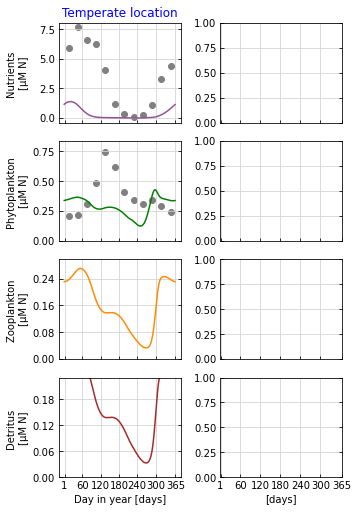

In [81]:
numcols = 2
f1, (ax1, ax2, ax3, ax4) = plt.subplots(4, numcols, sharex='col', constrained_layout=True)#, sharey='row')

plt.setp((ax1, ax2, ax3, ax4), xticks=[1,60,120,180,240,300,365])
from matplotlib.ticker import MaxNLocator
for axe in (ax1, ax2, ax3, ax4):
    for i in range(numcols):
        
        axe[i].grid(True, color='lightgrey')
        axe[i].get_yaxis().set_major_locator(MaxNLocator(nbins=4))
        axe[i].tick_params(top=False, right=True, direction="in")
        

# color vectors
#colors = ['#edc951', '#dddddd', '#00a0b0', '#343436', '#cc2a36']
colors = ['#808080','#d55e00', '#cc79a7', '#0072b2', '#009e73', 'grey']

lws = [2, 2.5, 4, 5.5]

def modeloutputplot(i, outarrayx, ms):
    timedays_ly = np.arange(0, 365)  # timedays[1:366]
    #outarray_ly = outarrayx[1460:1825]
    
    N_Max = np.max(out_ds.N__value.values[1460:1825]) + np.max(out_ds.N__value.values[1460:1825]) * 0.1
    Pall = out_ds.P__value.values[1460:1825]
    P_Max = np.max(Chla_Verif) + 0.1 * np.max(Pall)
    Zall = out_ds.Z__value.values[1460:1825]
    Z_Max = np.max(Zall) + 0.1 * np.max(Zall)
    D_Max = np.max(out_ds.D__value.values[1460:1825]) + 0.2 * np.max(out_ds.D__value.values[1460:1825])
    
    if i == 0:
        ax1[i].set_title('Temperate location', color='blue')
    else:
        ax1[i].set_title('Tropical location', color='red')
        

    #print(outarrayx)

    dayspermonth = [31, 28, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31]
    dpm_cumsum = np.cumsum(dayspermonth) - np.array(dayspermonth)/2 #- 15
    #print(timedays_ly)


    # Figure 1
    # N
    ax1[i].scatter(dpm_cumsum, Nut_Verif, label='WOA data', c='grey')
    ax1[i].plot(timedays_ly, out_ds.N__value.values[1460:1825], c=culrNPZD[0], label='N')
    if i == 0:
        ax1[i].set_ylabel('Nutrients \n' '[µM N]', multialignment='center', fontsize=10)
    
    #ax1[i].set_ylim(0, 10)
    #ax1[1].set_ylim(0, 3)
    if i == 1:
        ax1[i].legend(fontsize='x-small')


    ChlConv = True
    # Phyto
    CtoChla = 75  # g/g
    MolarMassC = 12.0107
    CtoNratioPhyto = 6.625
    muMolartoChlaconvfactor = CtoChla / MolarMassC / CtoNratioPhyto  # Chla as mg/m-3 to

    ax2[i].scatter(dpm_cumsum, np.array(Chla_Verif) * muMolartoChlaconvfactor, label='MODISaq data', c='grey')



    ax2[i].plot(timedays_ly, Pall, c=culrNPZD[1],  label='P')
    if i == 1:
        ax2[i].legend(fontsize='x-small')
        
    if i == 0:
        ax2[i].set_ylabel('Phytoplankton \n' '[µM N]', multialignment='center', fontsize=10)
    ax2[i].set_ylim(0, P_Max)
    #ax2[1].set_ylim(0, 1)
    # Z

    ax3[i].plot(timedays_ly, Zall, c=culrNPZD[2], label='Z')
    if i == 0:
        ax3[i].set_ylabel('Zooplankton \n' '[µM N]', multialignment='center', fontsize=10)
        ax4[i].set_ylabel('Detritus \n' '[µM N]', multialignment='center', fontsize=10)
    ax3[i].tick_params('y', labelsize=10)
    ax3[i].set_ylim(0, Z_Max)
    #ax4[i_plot].set_title('Zooplankton')

    
    # D
    ax4[i].plot(timedays_ly, out_ds.Z__value.values[1460:1825], c=culrNPZD[3], label='D')
    #ax3[i].set_ylabel('Detritus \n' '[µM N]', multialignment='center', fontsize=9)
    ax4[i].set_ylim(0,D_Max)
    #ax3[1].set_ylim(0,0.1)
    ax4[0].set_xlabel('Day in year [days]')
    ax4[1].set_xlabel('[days]')
    if i == 1:
        ax3[i].legend(fontsize='x-small')
        ax1[i].set_yticklabels([])
        ax2[i].set_yticklabels([])
        ax3[i].set_yticklabels([])
        ax4[i].set_yticklabels([])
    # Legend

    
    
modeloutputplot(0, 0, 0)
#modeloutputplot(1, outarray2,ms2)
# ax1[muplot].invert_yaxis()

# Defining custom 'xlim' and 'ylim' values.
#xlim = (0, 365)

# Setting the values for all axes.
plt.setp((ax1, ax2, ax3))#, xlim=xlim)

f1.align_ylabels()

#plt.tight_layout()

#plt.subplots_adjust(hspace=0.1, wspace=0.1)

#plt.savefig('../02_NPZDslab.pdf', bbox_inches='tight')
#plt.show()

In [1]:
import xsimlab as xs
import numpy as np

In [2]:
import os,sys,inspect
sys.path.insert(1, os.path.join(sys.path[0], '..'))

import phydra

In [3]:
from phydra.utility.xsimlabwrappers import phydra_setup

In [4]:
from phydra.processes.main import GekkoCore, GekkoContext, GekkoSequentialSolve, Time

from phydra.processes.statevars import StateVariable, FunctionalGroup

from phydra.processes.fluxes import (InFlux, LinearExchangeFlux,LinearLossFlux, MonodUptake, Growth_MultiLim, 
                                    GML_MonodUptake, GML_EppleyTempLim, GML_SteeleLightLim,
                                    GrazingFlux, GrazingFlux_MultiRessource,
                                    QuadraticLossFlux, QuadraticExchangeFlux, Mixing, Upwelling)

from phydra.processes.forcings import ConstantForcing, SinusoidalForcing, GlobalSlabClimatologyForcing

from phydra.processes.paramsetup import GrowthParameterSetup

In [7]:
from phydra.processes.forcings import Forcing

In [8]:
print('xarray-simlab version: ', xs.__version__)
print('phydra version: ', phydra.__version__)

xarray-simlab version:  0.4.1
phydra version:  0+untagged.93.g5bac7e0.dirty


In [9]:
MODEL = xs.Model({
                # CORE
                'core':GekkoCore, 
                'solver':GekkoSequentialSolve, 

                'time':Time, 
                
                # STATE VARIABLES
                'N':StateVariable, 
                'P':StateVariable,
                #'Z':StateVariable, 
                #'D':StateVariable,
                
                # FLUXES
                # setup classmethod allows multiple instances of Growth_MultiLim process
                # and GML_... processes in same model
                  # Pro: flexible, Con: less understandable code
                
                'monod':MonodUptake,
                #'growth':Growth_MultiLim.setup('_P'),
                #'monod':GML_MonodUptake.setup('_P'),
                
                #'eppley':GML_EppleyTempLim.setup('_P'),
                #'steele':GML_SteeleLightLim.setup('_P'),

                # note, grazing does not include setup class method (only 1 instance possible)
                  # (design choice not yet settled)
                #'grazing':GrazingFlux_MultiRessource,
                
                'P_mortality':LinearLossFlux,
                #'P_quadmortality':QuadraticExchangeFlux,
                #'Z_mortality':LinearExchangeFlux,
                #'Z_quadmortality':QuadraticLossFlux,
    
                #'D_remin':LinearExchangeFlux,
    
                'Mixing': Mixing,
    
                'N_upwelling':Upwelling,
                
                # FORCING
                'N0':ConstantForcing,
                #'Temp':GlobalSlabClimatologyForcing,
                #'I0':GlobalSlabClimatologyForcing,
                'MLD':GlobalSlabClimatologyForcing,
                })

MODEL

<xsimlab.Model (11 processes, 23 inputs)>
core
solver
time
    days             [in] ('time',) time in days
N
    initVal          [in] initial value of component
P
    initVal          [in] initial value of component
MLD
    rbb              [in]
    lon              [in]
    lat              [in]
    k                [in] The degree of the spline fit
    smooth           [in] smoothing conditions, larger values = str...
    show_plot        [in] show plot of interpolated data and interp...
    dataset          [in] Options: 'n0x', 'mld', 'tmld', 'par'
N0
    initVal          [in]
monod
    sink_label       [in]
    halfsat          [in] half saturation constant for Monod growth
    source_label     [in]
P_mortality
    rate             [in] linear loss rate
    SV_label         [in]
Mixing
    FX_label_MLD     [in] MLD forcing label
    kappa            [in] constant diffusive mixing rate
    SV_labels        [in] ('loss_index',) 
N_upwelling
    FX_label_N0      [in] N0 forcing labe

In [10]:
in_ds = phydra_setup(model=MODEL,
                        input_vars={
                            'time__days': ('time', np.arange(0, 365*5)),
                            
                            'N':{'initVal':0.1},
                            'P':{'initVal':.01},
                            #'Z':{'initVal':.01},
                            #'D':{'initVal':.01},
                            
                            #'growth':{'source_label':'N',
                            #'sink_label':'P',
                            #          'mumax':1.},
                            'monod':{'halfsat':0.5,
                                    'source_label':'N',
                                      'sink_label':'P'},
                            #'eppley':{'FX_label':'Temp',
                            #          'exponent':0.063},
                            #'steele':{'FX_label_I0':'I0',
                            #          'FX_label_MLD':'MLD',
                            #          'IOpt':20.,
                            #          'kw':0.04,
                            #          'kc':0.03},
                            
                            #'grazing':{'source_labels':['P','D'],
                            #           'sink_label':'Z',
                            #           'egested2_label':'D',
                            #           'excreted2_label':'N',
                                       
                            #           'Imax':1.,
                            #           'kZ':0.6,
                            #           'epsilon':0.75,
                            #           'beta':0.69,
                                      
                            #           'feed_prefs':[0.67, 0.33]},
                            
                            'P_mortality':{'SV_label':'P',
                                           'rate':0.1},
                            
                            #'P_mortality':{'source_label':'P',
                            #               'sink_label':'D',
                            #               'rate':0.015},
                            
                            #'P_quadmortality':{'source_label':'P',
                            #               'sink_label':'D',
                            #               'rate':0.025},
                            
                            #'Z_mortality':{'source_label':'Z',
                            #               'sink_label':'D',
                            #               'rate':0.02},
                            
                            #'Z_quadmortality':{'SV_label':'Z',
                            #               'rate':0.34},
                            
                            #'D_remin':{'source_label':'D',
                            #           'sink_label':'N',
                            #           'rate':0.06},
                            
                            'Mixing':{'SV_labels':['P'], #,'Z','D'],
                                      'FX_label_MLD':'MLD',
                                      'kappa':0.1},
                            
                            'N_upwelling':{'SV_label':'N',
                                      'FX_label_MLD':'MLD',
                                      'FX_label_N0':'N0',
                                      'kappa':0.1},
                            
                            'N0':{'initVal':1},#{'lat':40,'lon':20,'rbb':2,'smooth':1,
                                 #  'dataset':'n0x'},
                            #'Temp':{'lat':40,'lon':20,'rbb':2,'smooth':100,
                            #       'dataset':'tmld'},
                            #'I0':{'lat':40,'lon':20,'rbb':2,'smooth':.01,
                            #       'dataset':'par'},
                            'MLD':{'lat':40,'lon':20,'rbb':2,'smooth':400, 'k':2,
                                   'dataset':'mld', 'show_plot':True}

                        },
                        output_vars={
                            # State Variables
                            'N__value':None,
                            'P__value':None,
                            #'Z__value':None,
                            #'D__value':None,
                            
                            # Fluxes
                            'monod__value':None,
                            'P_mortality__value':None,
                            #'P_quadmortality__value':None,
                            #'Z_mortality__value':None,
                            #'Z_quadmortality__value':None,
                            #'grazing__values':None,
                            
                            # Forcing
                            'N0__value':None,
                            'MLD__value':None,
                            'MLD__deriv':None,
                            #'Temp__value':None,
                            #'I0__value':None,
                            
                            # Forcing Fluxes
                            'N_upwelling__value':None,
                            #'Mixing__values':None
                        })

initializing model core
Initializing Model Time
state variable N is initialized
state variable P is initialized
forcing MLD is initialized
[51.53923035 59.66986465 42.80987167 30.42244339 16.89489937 12.89269829
 11.22776413 11.333992   11.86169243 16.29351425 24.7042942  25.36184311
 43.40859222 51.53923035] [  0.   15.5  45.   74.5 105.  135.5 166.  196.5 227.5 258.  288.5 319.
 349.5 365. ]


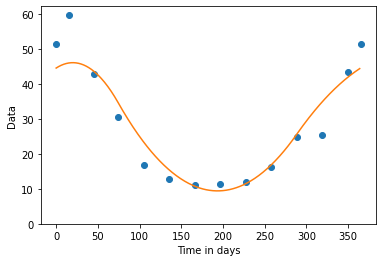

[51.53923035 59.66986465 42.80987167 30.42244339 16.89489937 12.89269829
 11.22776413 11.333992   11.86169243 16.29351425 24.7042942  25.36184311
 43.40859222 51.53923035] [  0.   15.5  45.   74.5 105.  135.5 166.  196.5 227.5 258.  288.5 319.
 349.5 365. ]


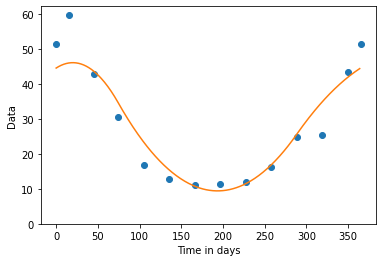

forcing N0 is initialized
flux monod of P consuming N is initialized
flux P_mortality acting on P is initialized
flux Mixing acting on ['P'] is initialized
['P']
[((p)*((((hpos+0.1))/(mld))))]
flux N_upwelling acting on N is initialized
assembling equations for state variable N
defaultdict(<class 'list'>, {'N': [(-((((n)/((0.5+n))))*(p))), (((n0-n))*((((hpos2+0.1))/(mld))))], 'P': [((((n)/((0.5+n))))*(p)), (-((p)*(0.1))), (-((p)*((((hpos+0.1))/(mld)))))]})
assembling equations for state variable P
defaultdict(<class 'list'>, {'N': [(-((((n)/((0.5+n))))*(p))), (((n0-n))*((((hpos2+0.1))/(mld))))], 'P': [((((n)/((0.5+n))))*(p)), (-((p)*(0.1))), (-((p)*((((hpos+0.1))/(mld)))))]})
['time', 'n', 'p']
Running solver now
Model was solved in 16.29 seconds
finalizing gekko core: cleanup


In [11]:
with MODEL:
    out_ds = in_ds.xsimlab.run()

In [12]:
print(out_ds)

<xarray.Dataset>
Dimensions:                    (clock: 2, loss_index: 1, time: 1825)
Coordinates:
  * clock                      (clock) int64 0 1
  * time                       (time) int64 0 1 2 3 4 ... 1821 1822 1823 1824
Dimensions without coordinates: loss_index
Data variables:
    MLD__dataset               <U3 'mld'
    MLD__deriv                 (time) float64 0.1543 0.1465 ... 0.1592 0.1567
    MLD__k                     int64 2
    MLD__lat                   int64 40
    MLD__lon                   int64 20
    MLD__rbb                   int64 2
    MLD__show_plot             bool True
    MLD__smooth                int64 400
    MLD__value                 (time) float64 44.54 44.69 44.83 ... 44.23 44.38
    Mixing__FX_label_MLD       <U3 'MLD'
    Mixing__SV_labels          (loss_index) <U1 'P'
    Mixing__kappa              float64 0.1
    N0__initVal                int64 1
    N0__value                  (time) float64 1.0 1.0 1.0 1.0 ... 1.0 1.0 1.0
    N__initVal         

In [13]:
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [12, 5]

In [14]:
MLDval = out_ds.MLD__value.values
MLDderv = out_ds.MLD__deriv.values

In [15]:
K = (np.maximum(MLDderv, 0) + 0.1) / MLDval

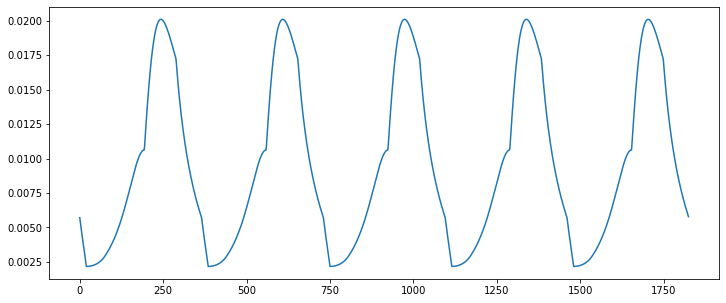

In [16]:
plt.plot(K * 1)

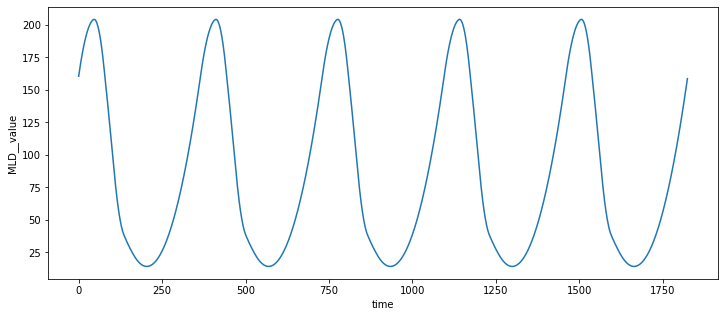

In [28]:
out_ds.MLD__value.plot.line(x='time')

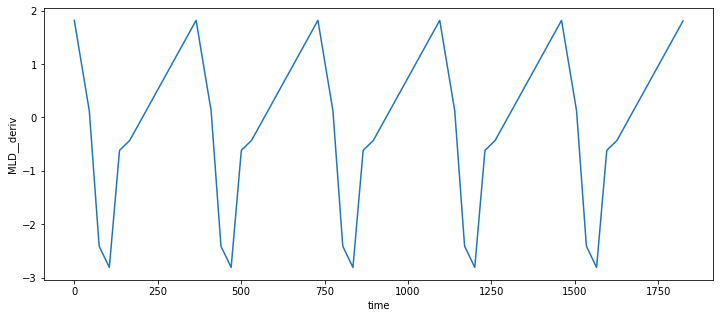

In [29]:
out_ds.MLD__deriv.plot.line(x='time')

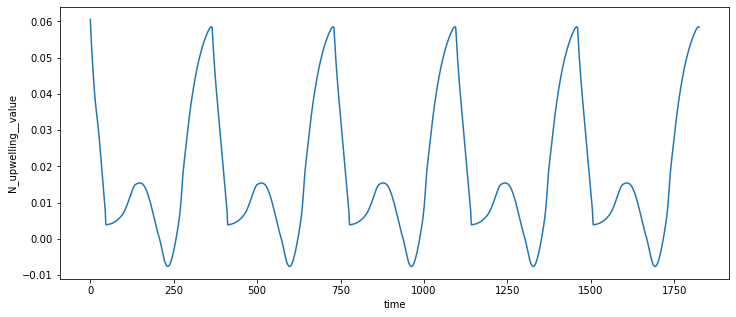

In [30]:
out_ds.N_upwelling__value.plot.line(x='time')

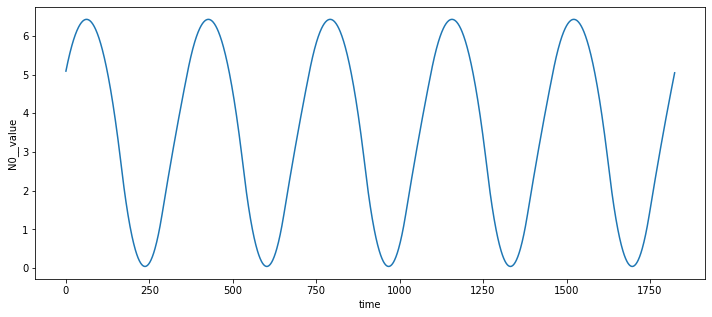

In [31]:
out_ds.N0__value.plot.line(x='time')

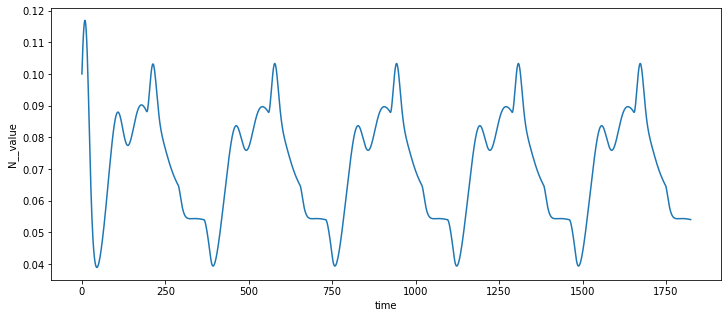

In [32]:
out_ds.N__value.plot.line(x='time')

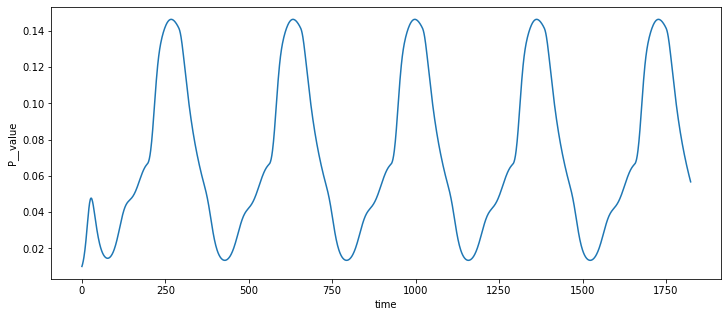

In [33]:
out_ds.P__value.plot.line(x='time')

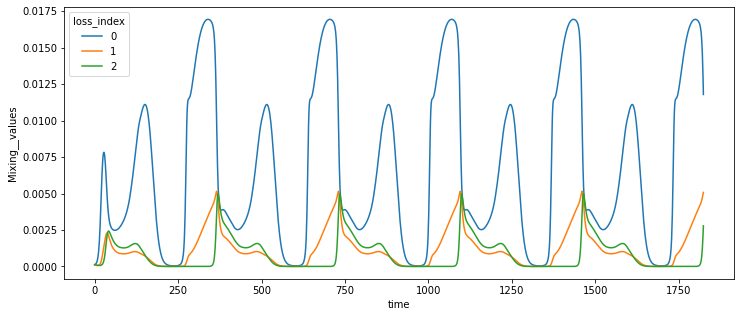

In [32]:
out_ds.Mixing__values.plot.line(x='time')

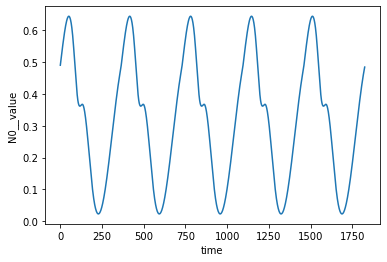

In [13]:
out_ds.N0__value.plot.line(x='time')
#out_ds.Temp__value.plot.line(x='time')
#out_ds.MLD__value.plot.line(x='time')
#out_ds.I0__value.plot.line(x='time')

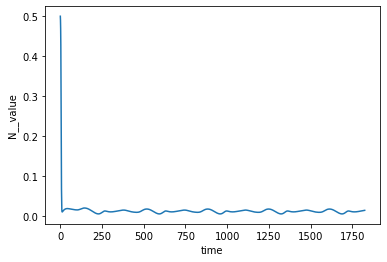

In [14]:
out_ds.N__value.plot.line(x='time')

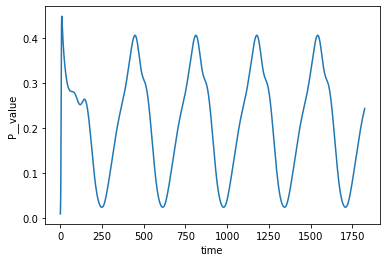

In [15]:
out_ds.P__value.plot.line(x='time')

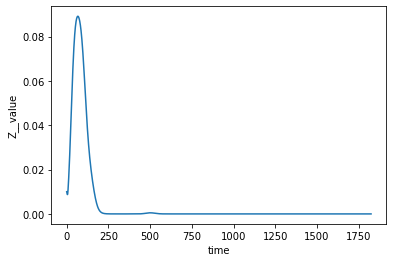

In [16]:
out_ds.Z__value.plot.line(x='time')

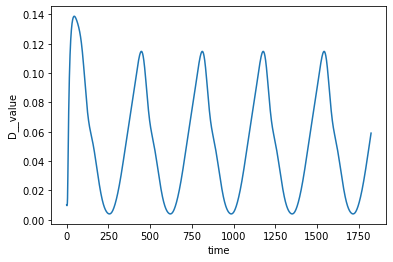

In [17]:
out_ds.D__value.plot.line(x='time')

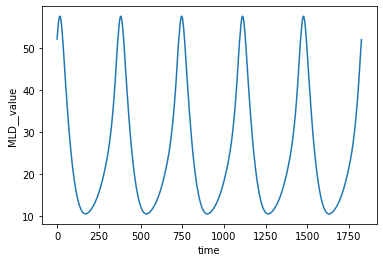

In [17]:
out_ds.MLD__value.plot.line(x='time')

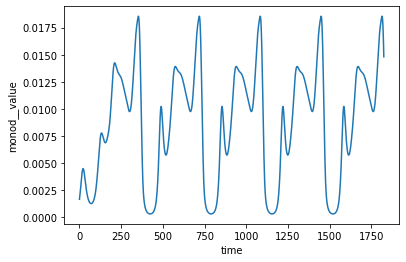

In [19]:
out_ds.monod__value.plot.line(x='time')

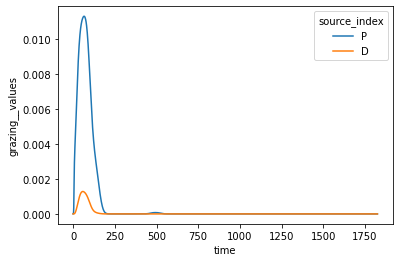

In [19]:
out_ds.grazing__values.plot.line(x='time')

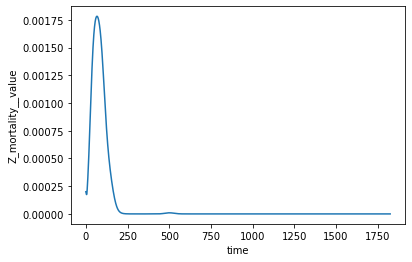

In [20]:
out_ds.Z_mortality__value.plot.line(x='time')

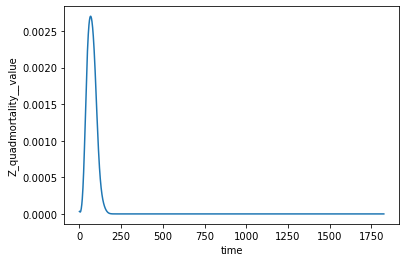

In [21]:
out_ds.Z_quadmortality__value.plot.line(x='time')

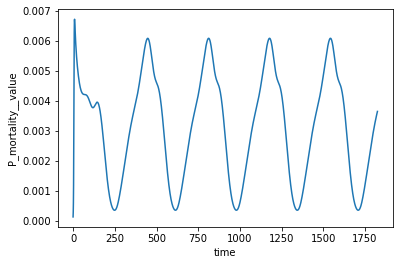

In [22]:
out_ds.P_mortality__value.plot.line(x='time')

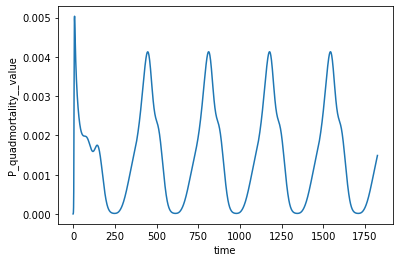

In [23]:
out_ds.P_quadmortality__value.plot.line(x='time')

In [21]:
##########################

In [1]:
import os,sys,inspect
sys.path.insert(1, os.path.join(sys.path[0], '..'))

import phydra

In [2]:
from phydra.utility.forcingdata import ClimatologyForcing

In [3]:
lat=40
lon=20
rbb=2
smooth=1000                                   
dataset='mld'

data = ClimatologyForcing(lat, lon, rbb, dataset)

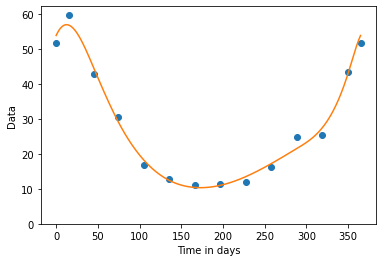

In [4]:
from phydra.processes.forcings import interpolate_monthly_climatology, return_discretized_forcing

spline = interpolate_monthly_climatology(data.outForcing, show_plot=True)

In [6]:
import numpy as np
return_discretized_forcing(spline, np.arange(0,366))

array([53.81199807, 54.31245804, 54.7650234 , 55.17079718, 55.53088241,
       55.84638211, 56.1183993 , 56.34803701, 56.53639826, 56.68458608,
       56.79370349, 56.86485353, 56.8991392 , 56.89766354, 56.86152958,
       56.79184033, 56.68969882, 56.55620808, 56.39247114, 56.199591  ,
       55.97867071, 55.73081329, 55.45712176, 55.15869914, 54.83664846,
       54.49207275, 54.12607503, 53.73975832, 53.33422566, 52.91058005,
       52.46992454, 52.01336214, 51.54199588, 51.05692879, 50.55926388,
       50.05010419, 49.53055273, 49.00171254, 48.46468664, 47.92057805,
       47.37048979, 46.8155249 , 46.2567864 , 45.69537731, 45.13240065,
       44.56895946, 44.00600774, 43.44390347, 42.88285563, 42.32307316,
       41.76476504, 41.20814023, 40.65340769, 40.1007764 , 39.55045531,
       39.0026534 , 38.45757962, 37.91544295, 37.37645233, 36.84081676,
       36.30874517, 35.78044655, 35.25612986, 34.73600405, 34.22027811,
       33.70916098, 33.20286164, 32.70158905, 32.20555218, 31.71

In [26]:
data.outForcing

[59.669865,
 42.80987,
 30.422443,
 16.8949,
 12.892698,
 11.227764,
 11.333992,
 11.861692,
 16.293514,
 24.704294,
 25.361843,
 43.408592]

In [24]:

import scipy.interpolate as intrp

In [29]:
# to smooth out interpolated data, we append it by itself 3 times (over 3 years)
# and take the interpolated values from the middle year
dayspermonth = [31, 28, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31]
dpm = dayspermonth #* 3
dpm_cumsum = np.cumsum(dpm) - np.array(dpm) / 2

x = np.r_[dpm_cumsum, dpm_cumsum[0]]
y = np.r_[data.outForcing, data.outForcing[0]]

print(x)

print(y)

[ 15.5  45.   74.5 105.  135.5 166.  196.5 227.5 258.  288.5 319.  349.5
  15.5]
[59.669865 42.80987  30.422443 16.8949   12.892698 11.227764 11.333992
 11.861692 16.293514 24.704294 25.361843 43.408592 59.669865]


In [31]:

tck, u = intrp.splprep([dpm_cumsum, data.outForcing], s=10, per=True)
xi, yi = intrp.splev(np.arange(30, 300), tck)

print(xi)
print(yi)

[1.98120834e+08 2.19150915e+08 2.41618820e+08 2.65572091e+08
 2.91058270e+08 3.18124900e+08 3.46819522e+08 3.77189679e+08
 4.09282913e+08 4.43146766e+08 4.78828780e+08 5.16376497e+08
 5.55837460e+08 5.97259210e+08 6.40689289e+08 6.86175241e+08
 7.33764606e+08 7.83504928e+08 8.35443748e+08 8.89628608e+08
 9.46107050e+08 1.00492662e+09 1.06613485e+09 1.12977929e+09
 1.19590749e+09 1.26456698e+09 1.33580530e+09 1.40967000e+09
 1.48620862e+09 1.56546870e+09 1.64749778e+09 1.73234341e+09
 1.82005313e+09 1.91067448e+09 2.00425500e+09 2.10084224e+09
 2.20048373e+09 2.30322703e+09 2.40911966e+09 2.51820917e+09
 2.63054312e+09 2.74616902e+09 2.86513444e+09 2.98748691e+09
 3.11327398e+09 3.24254318e+09 3.37534205e+09 3.51171815e+09
 3.65171901e+09 3.79539218e+09 3.94278519e+09 4.09394559e+09
 4.24892092e+09 4.40775872e+09 4.57050654e+09 4.73721192e+09
 4.90792239e+09 5.08268551e+09 5.26154881e+09 5.44455984e+09
 5.63176614e+09 5.82321524e+09 6.01895470e+09 6.21903205e+09
 6.42349484e+09 6.632390

/Users/bpo/opt/miniconda3/envs/xsimlab/lib/python3.8/site-packages/scipy/interpolate/_fitpack_impl.py:225: RuntimeWarning: Setting x[0][12]=x[0][0]
  warnings.warn(RuntimeWarning('Setting x[%d][%d]=x[%d][0]' %
/Users/bpo/opt/miniconda3/envs/xsimlab/lib/python3.8/site-packages/scipy/interpolate/_fitpack_impl.py:225: RuntimeWarning: Setting x[1][12]=x[1][0]
  warnings.warn(RuntimeWarning('Setting x[%d][%d]=x[%d][0]' %


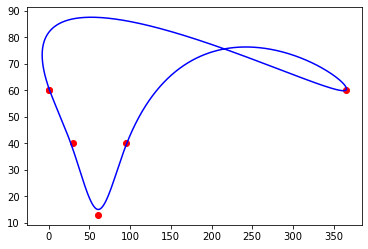

In [46]:
import numpy as np
from scipy import interpolate
from matplotlib import pyplot as plt

x = np.array([0, 30, 60, 95, 365])
y = np.array([60, 40, 13, 40, 60])

# append the starting x,y coordinates
x = np.r_[x, x[0]]
y = np.r_[y, y[0]]

# fit splines to x=f(u) and y=g(u), treating both as periodic. also note that s=0
# is needed in order to force the spline fit to pass through all the input points.
tck, u = interpolate.splprep([x, y], s=10, per=True)

# evaluate the spline fits for 1000 evenly spaced distance values
xi, yi = interpolate.splev(np.linspace(0, 1, 1000), tck)

# plot the result
fig, ax = plt.subplots(1, 1)
ax.plot(x, y, 'or')
ax.plot(xi, yi, '-b')

In [ ]:

# k=3 for cubic spline
self.interpolated_data = intrp.UnivariateSpline(dpm_cumsum, data.outForcing * 3, k=3, s=self.smooth)
self.interpolated_data_deriv = self.interpolated_data.derivative()

In [55]:
dpm_cumsum, data.outForcing

(array([ 15.5,  45. ,  74.5, 105. , 135.5, 166. , 196.5, 227.5, 258. ,
        288.5, 319. , 349.5]),
 [59.669865,
  42.80987,
  30.422443,
  16.8949,
  12.892698,
  11.227764,
  11.333992,
  11.861692,
  16.293514,
  24.704294,
  25.361843,
  43.408592])

In [77]:
np.linspace(0,365,12)

array([  0.        ,  33.18181818,  66.36363636,  99.54545455,
       132.72727273, 165.90909091, 199.09090909, 232.27272727,
       265.45454545, 298.63636364, 331.81818182, 365.        ])

In [95]:
time = np.concatenate([[0], dpm_cumsum, [365]], axis=0)

mean_int = [(data.outForcing[0] + data.outForcing[-1]) / 2]
dat = np.concatenate([mean_int, data.outForcing, mean_int])

In [96]:
time, dat

(array([  0. ,  15.5,  45. ,  74.5, 105. , 135.5, 166. , 196.5, 227.5,
        258. , 288.5, 319. , 349.5, 365. ]),
 array([51.53923035, 59.66986465, 42.80987167, 30.42244339, 16.89489937,
        12.89269829, 11.22776413, 11.333992  , 11.86169243, 16.29351425,
        24.7042942 , 25.36184311, 43.40859222, 51.53923035]))

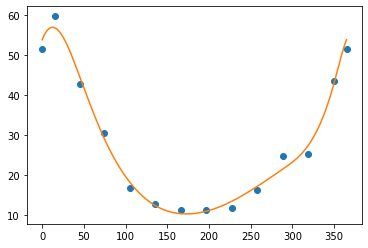

In [140]:
import matplotlib.pyplot as plt
from scipy.interpolate import splev, splrep

dayspermonth = [31, 28, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31]
dpm = dayspermonth #* 3
dpm_cumsum = np.cumsum(dpm) - np.array(dpm) / 2

time = np.concatenate([[0], dpm_cumsum, [365]], axis=None)

boundary_int = [(data.outForcing[0] + data.outForcing[-1]) / 2]
dat = np.concatenate([boundary_int, data.outForcing, boundary_int], axis=None)

spl = intrp.splrep(time, dat, per=True, k=3, s=40)
time_2int = np.linspace(0, 365, 1000)
dat_int = intrp.splev(time_2int, spl, der=0)
plt.plot(time, dat, 'o', time_2int, dat_int)
plt.show()

In [29]:
from phydra.processes.forcings import interpolate_monthly_climatology, return_discretized_forcing

interpolate_monthly_climatology(data.outForcing)

AttributeError: 'list' object has no attribute 'outForcing'

In [21]:
from phydra.processes.forcings import interpolate_monthly_climatology, return_discretized_forcing



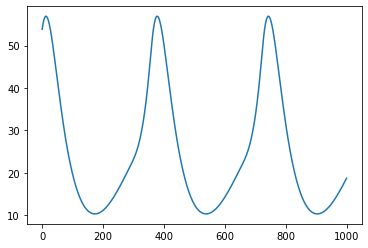

In [111]:
x3 = np.arange(0,1000)

y4 = splev(np.mod(x3, 365), spl)


plt.plot(x3, y4)
plt.show()

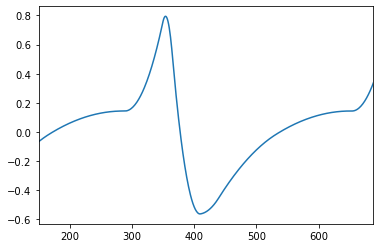

In [128]:
x3 = np.arange(0,1000)

y4 = splev(np.mod(x3, 365), spl, der=1)


plt.plot(x3, y4)
plt.xlim((150,688))
plt.show()

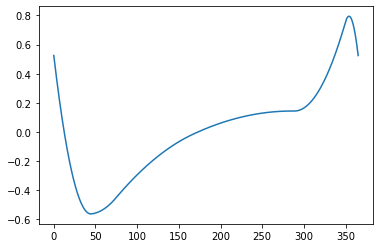

In [106]:
y3 = splev(x2, spl, der=1)

plt.plot(x2, y3)
plt.show()

# OLD CODE

In [1]:
import numpy as np
import xsimlab as xs

In [2]:
import os,sys,inspect
sys.path.insert(1, os.path.join(sys.path[0], '..'))

import phydra as phydra

In [3]:
from phydra.utility.xsimlabwrappers import phydra_setup

In [7]:
from phydra.processes.main import Grid0D, Boundary0D
from phydra.processes.components import Component, Time, make_Component
from phydra.processes.environments import BaseEnvironment, Slab
from phydra.processes.fluxes import (BaseFlux, LimitedGrowth_Monod, 
                                     LimitedGrowth_MonodTempLight,  
                                     LinearMortality, 
                                     HollingTypeIII, make_flux, make_multigrazing)
from phydra.processes.forcingfluxes import (LinearMortalityClosure, Mixing, Sinking, 
                                            Upwelling, make_FX_flux)
from phydra.processes.forcing import (SinusoidalMLD, ConstantN0, WOA2018_MLD, 
                                      WOA2018_N0, MODISaq_PAR, WOA2018_Tmld, 
                                      ConstantPAR, ConstantTemp)
from phydra.processes.gekkocontext import GekkoContext, GekkoSolve, InheritGekkoContext

In [8]:
from phydra.processes.forcing import NutrientForcing, MLDForcing

In [9]:
print('xarray-simlab version: ', xs.__version__)
print('phydra version: ', phydra.__version__)

xarray-simlab version:  0.4.1
phydra version:  0+untagged.82.g7e99bc8.dirty


In [12]:
model = xs.Model({
    'time':Time, 'grid':Grid0D, 'ibcs':Boundary0D, 
    
    'context':GekkoContext,
                  
    'N':make_Component('Nutrient','N', comp_type=Component), 'P':make_Component('Phytoplankton','P', comp_type=Component),
    'Z':make_Component('Zooplankton','Z', comp_type=Component), 'D':make_Component('Detritus','D', comp_type=Component),
    'Env':Slab, 
    
    # Fluxes
    'P_Growth':make_flux(LimitedGrowth_Monod, 'G'), 
     
    'P_LinMortality':make_FX_flux(LinearMortalityClosure, 'P'),
    
    'Grazing':make_multigrazing(HollingTypeIII, 'X'), 
    
    # Closure (i.e. output from system)
    'Z_LinMortality':make_FX_flux(LinearMortalityClosure, 'Z'),
    
    # ForcingFluxes
    #'Sinking':make_FX_flux(Sinking, 'S'),
    'Upwelling':make_FX_flux(Upwelling, 'U'),
    
    'MLD':WOA2018_MLD, 
    'N0':ConstantN0, 
    'PAR':MODISaq_PAR,
    'Temp':WOA2018_Tmld,
    
    'solver':GekkoSolve
})

model

<xsimlab.Model (19 processes, 41 inputs)>
context
time
    days               [in] ('time',) time in days
grid
    shape              [in]
    length             [in]
ibcs
    ibc                [in] Initial Boundary Conditions
N
    init               [in]
    dim                [in]
P
    dim                [in]
    init               [in]
Z
    dim                [in]
    init               [in]
D
    dim                [in]
    init               [in]
P_Growth
    halfsat_min        [in] half-saturation constant of nutrient up...
    halfsat_max        [in] half-saturation constant of nutrient up...
    mu_max             [in] Maximum growth rate of component
    C_label            [in] label of component that grows
    mu_min             [in] Maximum growth rate of component
    R_label            [in] label of ressource component that is co...
Temp
    lat                [in]
    smooth             [in] smoothing factor used to choose number ...
    rbb                [in]
    lo

In [13]:
model.index_vars 


[('time', 'time'),
 ('N', 'N'),
 ('P', 'P'),
 ('Z', 'Z'),
 ('D', 'D'),
 ('Env', 'components'),
 ('Env', 'fluxes'),
 ('Env', 'forcingfluxes'),
 ('Env', 'forcings'),
 ('P_Growth', 'G'),
 ('P_LinMortality', 'P'),
 ('Grazing', 'X'),
 ('Z_LinMortality', 'Z'),
 ('Upwelling', 'U')]

In [14]:
ForcingLocation = {
    'lat':40,
    'lon':20,
    'rbb':2, 
    'smooth':100
}
ForcingLocationNOSMOOTH = ForcingLocation.copy()
ForcingLocationNOSMOOTH['smooth'] = 1

In [15]:
in_ds = phydra_setup(
    model=model,
    input_vars={
        'time__days': ('time', np.arange(0, 365*3)), #365*
        
        'N':{'dim':1,'init':.1}, 
        'P':{'dim':1,'init':.1},
        'Z':{'dim':1,'init':0.1},
        'D':{'dim':1,'init':2.1},
        
     'P_Growth':{'mu_min':0.7,
                   'mu_max':0.73,
               'halfsat_min':0.67,
               'halfsat_max':0.7,
               'R_label':'N',
               'C_label':'P'
                   
                #'kw':0.04,
                #'kc':0.03,
                #'OptI':30
                   },
        
        'Grazing':{'Imax':0.5,
               'halfsat':1.,
               'R_feed_prefs':[0.67, 0.33],
               'R_labels':['P','D'],
               #'C_labels':['Z']},
               #'R_label':'P',
               'C_label':'Z'},
        
                
        'P_LinMortality':{'mortality_rate':0.1,
               'C_labels':['P']},
        
        'Z_LinMortality':{'mortality_rate':0.1,
               'C_labels':['Z']},
        
        #'Sinking':{'kappa':0.,
        #       'C_labels':['P']},
        
        'Upwelling':{'kappa':0.,
               'C_labels':['N']},
        
        'PAR':ForcingLocationNOSMOOTH,
        'Temp':ForcingLocationNOSMOOTH,
        'N0__value':2,
        'MLD':ForcingLocation
    },
    output_vars={
        'Env__comp_output':None,
        'Env__flux_output':None,
        'Env__fxflux_output':None,
        'Env__forcing_output':None
    }
                 )

KeyError: "('Grazing', 'R_feed_prefs'), ('Grazing', 'R_labels') is/are not valid key(s) for input variables in model <xsimlab.Model (19 processes, 41 inputs)>\ncontext\ntime\n    days               [in] ('time',) time in days\ngrid\n    shape              [in]\n    length             [in]\nibcs\n    ibc                [in] Initial Boundary Conditions\nN\n    init               [in]\n    dim                [in]\nP\n    dim                [in]\n    init               [in]\nZ\n    dim                [in]\n    init               [in]\nD\n    dim                [in]\n    init               [in]\nP_Growth\n    halfsat_min        [in] half-saturation constant of nutrient up...\n    halfsat_max        [in] half-saturation constant of nutrient up...\n    mu_max             [in] Maximum growth rate of component\n    C_label            [in] label of component that grows\n    mu_min             [in] Maximum growth rate of component\n    R_label            [in] label of ressource component that is co...\nTemp\n    lat                [in]\n    smooth             [in] smoothing factor used to choose number ...\n    rbb                [in]\n    lon                [in]\nGrazing\n    Imax               [in] maximum grazing rate for consumer\n    C_label            [in] label of component that grazes\n    R_label            [in] labels of components that is grazed upon\n    halfsat            [in] label of component that grazes\nMLD\n    rbb                [in]\n    lon                [in]\n    smooth             [in] smoothing factor used to choose number ...\n    lat                [in]\nN0\n    value              [in] value of the constant forcing\nUpwelling\n    kappa              [in] constant mixing coefficient\n    C_labels           [in] u label of component(s) that grows\nZ_LinMortality\n    mortality_rate     [in] mortality rate of component\n    C_labels           [in] z label of component(s) that grows\nPAR\n    lat                [in]\n    smooth             [in] smoothing factor used to choose number ...\n    rbb                [in]\n    lon                [in]\nP_LinMortality\n    mortality_rate     [in] mortality rate of component\n    C_labels           [in] p label of component(s) that grows\nEnv\nsolver\n"

In [11]:
with model:
    out_ds = in_ds.xsimlab.run()

NameError: name 'in_ds' is not defined

In [12]:
out_ds

<xarray.Dataset>
Dimensions:                         (D: 1, G: 1, N: 1, P: 1, R: 2, U: 1, X: 2, Z: 1, clock: 2, components: 4, fluxes: 3, forcingfluxes: 3, forcings: 4, p: 1, time: 1095, u: 1, z: 1)
Coordinates:
  * D                               (D) <U1 'D'
  * G                               (G) <U14 'P_Growth-N-2-P'
  * N                               (N) <U1 'N'
  * P                               (P) <U1 'P'
  * U                               (U) <U11 'Upwelling-N'
  * X                               (X) <U13 'Grazing-P-2-Z' 'Grazing-D-2-Z'
  * Z                               (Z) <U1 'Z'
  * clock                           (clock) int64 0 1
  * components                      (components) <U1 'N' 'P' 'Z' 'D'
  * fluxes                          (fluxes) <U14 'Grazing-P-2-Z' ... 'P_Growth-N-2-P'
  * forcingfluxes                   (forcingfluxes) <U16 'P_LinMortality-P' ... 'Upwelling-N'
  * forcings                        (forcings) <U4 'N0' 'Temp' 'MLD' 'PAR'
  * time                            (time) int64 0 1 2 3 ... 1091 1092 1093 1094
Dimensions without coordinates: R, p, u, z
Data variables:
    D__dim                          int64 1
    D__init                         float64 2.1
    Env__comp_output                (components, time) float64 0.1 ... 2.2
    Env__flux_output                (fluxes, time) float64 0.02 ... 0.02367
    Env__forcing_output             (forcings, time) float64 2.0 2.0 ... 13.08
    Env__fxflux_output              (forcingfluxes, time) float64 -0.01 ... 0.02378
    Grazing__C_label                <U1 'Z'
    Grazing__Imax                   float64 0.5
    Grazing__R_feed_prefs           (R) float64 0.67 0.33
    Grazing__R_labels               (R) <U1 'P' 'D'
    Grazing__halfsat                float64 1.0
    MLD__lat                        int64 40
    MLD__lon                        int64 20
    MLD__rbb                        int64 2
    MLD__smooth                     int64 100
    N0__value                       int64 2
    N__dim                          int64 1
    N__init                         float64 0.1
    PAR__lat                        int64 40
    PAR__lon                        int64 20
    PAR__rbb                        int64 2
    PAR__smooth                     int64 1
    P_Growth__C_label               <U1 'P'
    P_Growth__R_label               <U1 'N'
    P_Growth__halfsat_max           float64 0.7
    P_Growth__halfsat_min           float64 0.67
    P_Growth__mu_max                float64 0.73
    P_Growth__mu_min                float64 0.7
    P_LinMortality__C_labels        (p) <U1 'P'
    P_LinMortality__mortality_rate  float64 0.1
    P__dim                          int64 1
    P__init                         float64 0.1
    Temp__lat                       int64 40
    Temp__lon                       int64 20
    Temp__rbb                       int64 2
    Temp__smooth                    int64 1
    Upwelling__C_labels             (u) <U1 'N'
    Upwelling__kappa                float64 0.0
    Z_LinMortality__C_labels        (z) <U1 'Z'
    Z_LinMortality__mortality_rate  float64 0.1
    Z__dim                          int64 1
    Z__init                         float64 0.1
    grid__length                    int64 1
    grid__shape                     int64 1
    ibcs__ibc                       float64 nan
    time__days                      (time) int64 0 1 2 3 ... 1091 1092 1093 1094

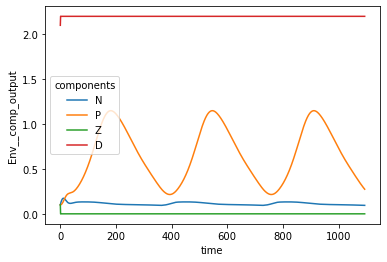

In [13]:
out_ds.Env__comp_output.plot.line(x='time')
#out_ds.Env__comp_output.isel(components=slice(1,-1)).sum(axis=0).plot.line(x='time')

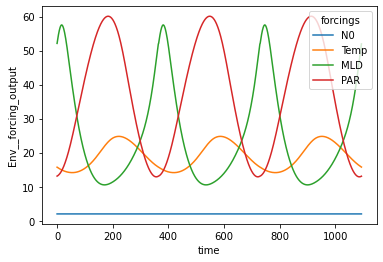

In [14]:
out_ds.Env__forcing_output.plot.line(x='time')

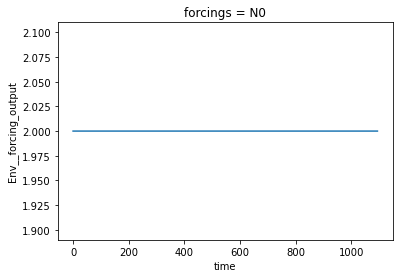

In [15]:
out_ds.Env__forcing_output.sel(forcings='N0').plot(x='time')  #, time=np.arange(300,400)

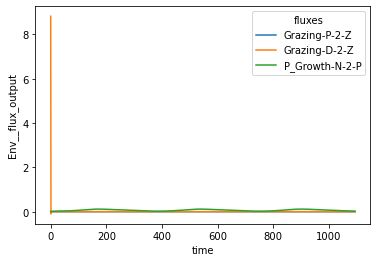

In [16]:
out_ds.Env__flux_output.plot.line(x='time')

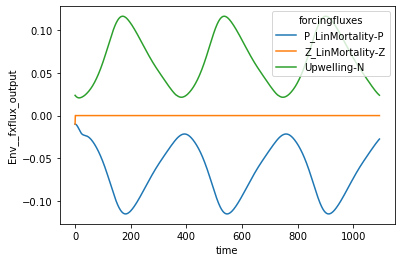

In [17]:
out_ds.Env__fxflux_output.plot.line(x='time')